## NLP B : TASK 2 
####- TALIKA GUPTA

In [1]:
#imports

import nltk, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [2]:
!pip install keras-nlp --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 5.3 MB/s 
     |████████████████████████████████| 4.6 MB 40.9 MB/s 
     |████████████████████████████████| 511.8 MB 7.7 kB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 511.7 MB 4.8 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.9 MB 50.0 MB/s 


In [3]:
print(tf.__version__)

2.8.2


In [4]:
import keras_nlp

In [5]:
## texts vs. labels
texts = ['you won a billion dollars , great work !',
'click here for cs685 midterm answers','read important cs685 news', 'send me your bank account info asap']
labels = np.array([1, 1, 0, 1])



## Preprocessing step and creating the embedding matrix using spacy

In [6]:

from keras.initializers import Constant
import spacy

maxlen = 10
nlp = spacy.load('en_core_web_sm') # loading the pretrained model
Vectorizer = layers.TextVectorization(output_sequence_length	= maxlen)

#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(np.array(texts))
vocab = Vectorizer.get_vocabulary()

#generate the embedding matrix
vocab_size = len(vocab)
print(vocab_size)
embed_dim = 96
embedding_matrix = np.zeros((vocab_size, embed_dim))
print(vocab)
# remove '' from vocab
vocab.pop(0) 
 
# creating the embedding matrix 
for i, word in enumerate(vocab):
  v = nlp(str(word)).vector.flatten()
  for j in range(0, 96):
    embedding_matrix[i][j] = v[j]

# Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=keras.layers.Embedding(
    vocab_size,
    output_dim=embed_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

25
['', '[UNK]', 'cs685', 'your', 'you', 'work', 'won', 'send', 'read', 'news', 'midterm', 'me', 'info', 'important', 'here', 'great', 'for', 'dollars', 'click', 'billion', 'bank', 'asap', 'answers', 'account', 'a']


In [7]:
print(Vectorizer(texts))

tf.Tensor(
[[ 4  6 24 19 17 15  5  0  0  0]
 [18 14 16  2 10 22  0  0  0  0]
 [ 8 13  2  9  0  0  0  0  0  0]
 [ 7 11  3 20 23 12 21  0  0  0]], shape=(4, 10), dtype=int64)


In [8]:
embed_dim = 96  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # feed forward layer dimension

## Defining the architecture of the transformer

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [10]:
inputs = layers.Input(shape=(maxlen,))
embedding = Embedding_layer(inputs)
positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
x = embedding + positional_encoding
print(x.shape)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

(None, 10, 96)


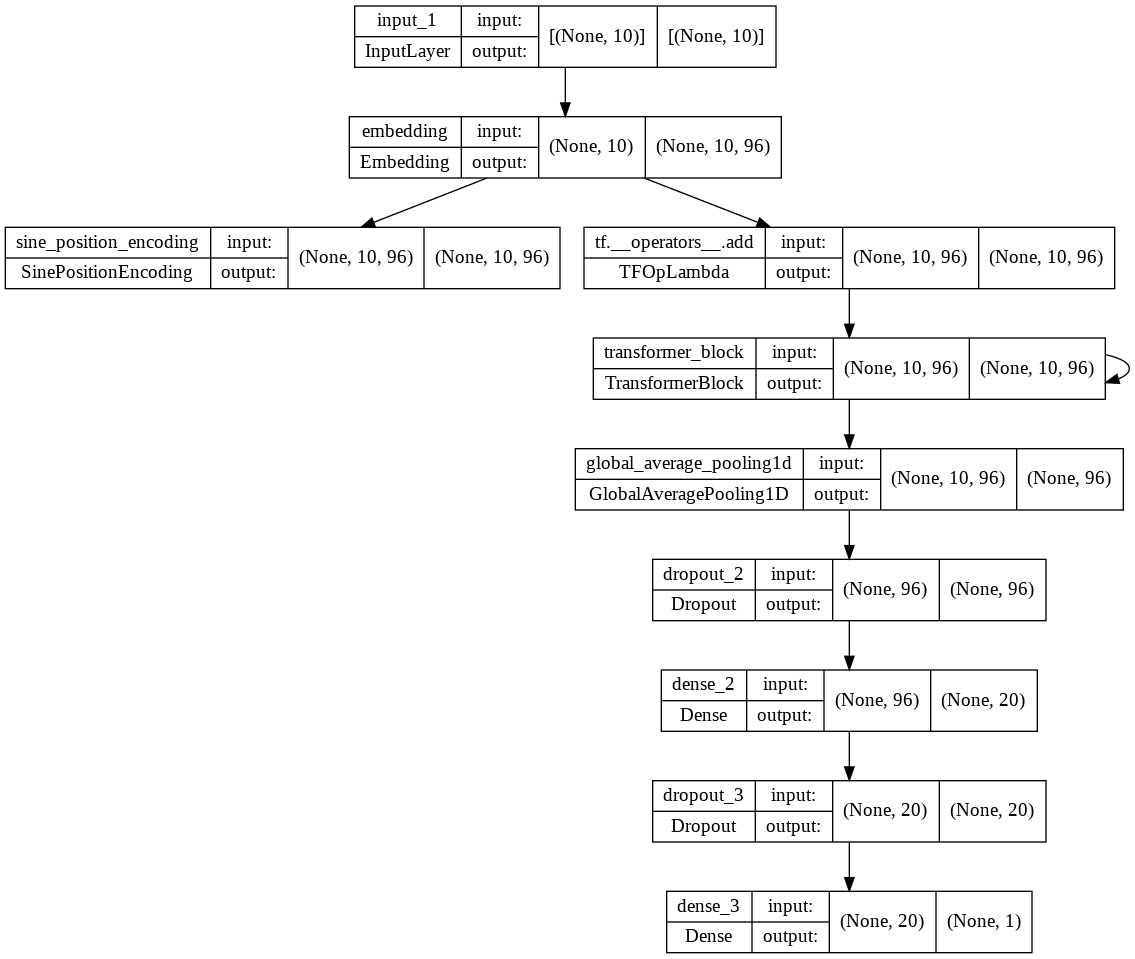

In [11]:
keras.utils.plot_model(model, show_shapes=True)


In [12]:
# compiling the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# vectoring the text input using the vectorizer layer
x_train = np.array(Vectorizer(texts))
y_train = np.array(labels)

history = model.fit(x_train,
                    y_train,
                    batch_size=4,
                    epochs=10,
                    validation_data=(x_train, y_train))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6029 - accuracy: 0.7500 - precision: 0.7500 - recall: 1.0000 - val_loss: 0.5120 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.4760 - accuracy: 0.7500 - precision: 0.7500 - recall: 1.0000 - val_loss: 0.4599 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4883 - accuracy: 0.7500 - precision: 0.7500 - recall: 1.0000 - val_loss: 0.3895 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.4081 - accuracy: 0.7500 - precision: 0.7500 - recall: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.4603 - accuracy: 0.7500 - precision: 0.7500 -

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_train_pred = model.predict(x_train)
y_pred = np.argmax(y_train_pred, axis=1)

# Print f1, precision, and recall scores
precision_score_num = precision_score(y_train, y_pred, average="macro")
recall_score_num = recall_score(y_train, y_pred, average="macro")
f1 = f1_score(y_train, y_pred , average="macro")
print(precision_score_num)
print(recall_score_num)
print(f1)

0.125
0.5
0.2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plotting loss

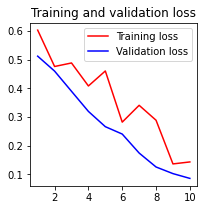

In [14]:
import matplotlib.pyplot as plt
import pandas as pd


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(3, 3))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving the results to csv file

In [15]:

df_res = pd.DataFrame({'precision': [precision_score_num], 'recall':[recall_score_num], 'F1' : [f1]})

print(df_res.head())

df_res.to_csv('/content/tensorflow_results.csv', index=False)



   precision  recall   F1
0      0.125     0.5  0.2
